In [256]:
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [338]:
#read in FEC data
#full_dataset = pickle.load(open('Datasets/data.p', 'rb'))
full_dataset = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018.p','rb'))
#full_dataset = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p','rb'))
#full_dataset = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p','rb'))
#full_dataset.head()
#1 =democratic party
# additional features to try: 
#"prior_margin_unsigned_minus","national_poll","national_poll_prior"]

In [198]:
full_dataset.columns

Index(['district', 'state', 'year', 'party', 'candidatevotes', 'totalvotes',
       'candidate', 'national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'previous_party', 'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev', 'dem_win', 'rep_win'],
      dtype='object')

In [339]:
#Create a sub-dataset
cols_to_use =["dem_win", "dem_win_prev",'year', 'state']#,
   #'margin_unsigned_divide_prev']#,\
              #'female_pct','age18_24_pct','age25_34_pct',\
             #'civilian_veteran_pct','bachelors_deg_or_higher_pct',\
             # 'unmarried_partner_pct','male_living_alone_pct',\
             #'speak_other_language_at_home_pct','foreign_born_proportion_from_LatinAmerica',\
             # 'foreign_to_native_born_ratio','labor_force_unemployed_pct',\
             #'public_transit_commuter_pct','no_health_insurance_pct',\
             # 'poverty_rate_pct','food_stamp_benefits_pct',\
             #'median_housing_value','median_household_income']
                
small_dataset =full_dataset[cols_to_use]

#add column to indicate a party flip
small_dataset['party_flip']= (small_dataset.dem_win_prev!=small_dataset.dem_win)*1

#add one hot encoder for states (with or without dropping first)
small_dataset = pd.get_dummies(small_dataset,'state',drop_first=True)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


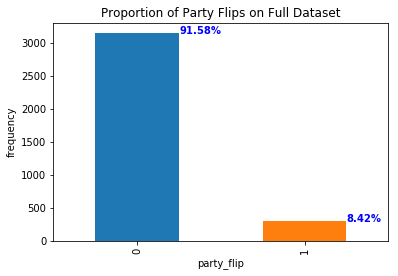

In [340]:

#print(small_dataset.shape)
#small_dataset.head()
plt.title('Proportion of districts that chage party in consecutive elections')
plt.ylabel('frequency')
plt.xlabel('Party Change')
small_dataset.party_flip.value_counts().plot(kind='bar')

#proportion of districts on the full data that do not flip
small_dataset.groupby('party_flip')['party_flip'].count().plot.bar()
plt.title('Proportion of Party Flips on Full Dataset')

for name, group in (small_dataset.groupby('party_flip')['party_flip']):
    plt.text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/small_dataset.shape[0]*100)+'%', color='blue', fontweight='bold')
 

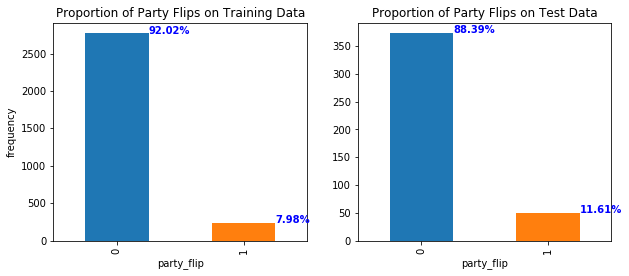

In [341]:
#split data into train and test and verify the distribution of party flips
test_data = small_dataset[small_dataset.year==2018]
train_data = small_dataset[small_dataset.year!=(2018)]

#train_data, test_data = train_test_split(small_dataset, test_size=.2, \
#                        stratify=small_dataset.party_flip,random_state=209)

#response variable
y_train=train_data["dem_win"]
y_test = test_data["dem_win"]

#predictors
X_train=train_data[small_dataset.columns.difference(["dem_win","year"])]
X_test=test_data[small_dataset.columns.difference(["dem_win","year"])]


#View the distribution of flips in train and test set

fig, ax = plt.subplots(1,2, figsize=(10,4))
X_train.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
X_test.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1])

#add title and axis
ax[0].set_title("Proportion of Party Flips on Training Data")
ax[0].set_ylabel("frequency")
ax[1].set_title("Proportion of Party Flips on Test Data")


#add bar numbers on training data plot
for name, group in (X_train.groupby('party_flip')['party_flip']):
    ax[0].text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/X_train.shape[0]*100)+'%', color='blue', fontweight='bold')
    
#add bar numbers on test data plot
for name, group in (X_test.groupby('party_flip')['party_flip']):
    ax[1].text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/X_test.shape[0]*100)+'%', color='blue', fontweight='bold')

Model R2 score:  0.9202392821535393
Test Accuracy:  0.8838862559241706
Confusion Matrix: 
 [[191   5]
 [ 44 182]]
Percent of non-party flips correctly predicted on test set 100.0 %
Percent of party flips correctly predicted on test set 0.0 %


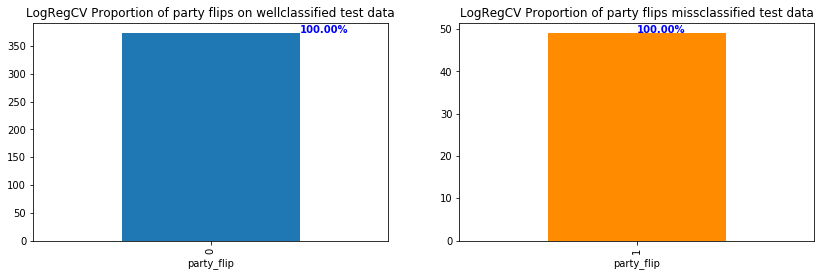

In [355]:
#Run Logistic CV model 
lr_model = LogisticRegressionCV(cv=5,random_state=209,multi_class='ovr',n_jobs=4)
lr_model.fit(X_train[X_train.columns.difference(["party_flip"])],y_train)
print("Model R2 score: ",lr_model.score(X_train[X_train.columns.difference(["party_flip"])],y_train))

#predict on test set
y_pred_test = lr_model.predict(X_test[X_test.columns.difference(["party_flip"])])
print("Test Accuracy: ",accuracy_score(y_test,y_pred_test))

#confusion metrics
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred_test))


#####
#looking at the missclassifications with logisticRegressionCV

miss_class_df = X_test[y_test != y_pred_test]
good_class_df = X_test[y_test == y_pred_test]

print("Percent of non-party flips correctly predicted on test set",
      (good_class_df.party_flip==0).sum() / (X_test.party_flip==0).sum()*100,'%')
print("Percent of party flips correctly predicted on test set",
      (good_class_df.party_flip==1).sum() / (X_test.party_flip==1).sum()*100,'%')


#plot the flips and non flips for each data
fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].set_title('LogRegCV Proportion of party flips on wellclassified test data')
ax[1].set_title('LogRegCV Proportion of party flips missclassified test data')

good_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
miss_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1],color='darkorange')

for name, group in (good_class_df.groupby('party_flip')['party_flip']):
    ax[0].text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/good_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

for name, group in (miss_class_df.groupby('party_flip')['party_flip']):
    ax[1].text(int(name)-1, group.count() + .10, \
    '{0:.2f}'.format(group.count()/miss_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

### QDA

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:686: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Model R2 score:  0.9202392821535393
Test Accuracy:  0.533175355450237
Confusion Matrix: 
 [[175  21]
 [176  50]]
Percent of non-party flips correctly predicted on test set 57.64075067024129 %
Percent of party flips correctly predicted on test set 20.408163265306122 %


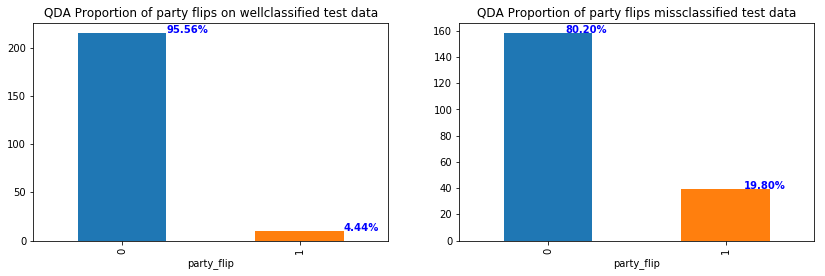

In [354]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

    #Run Logistic CV model 
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train[X_train.columns.difference(["party_flip"])],y_train)
print("Model R2 score: ",lr_model.score(X_train[X_train.columns.difference(["party_flip"])],y_train))

#predict on test set
y_pred_test = qda_model.predict(X_test[X_test.columns.difference(["party_flip"])])
print("Test Accuracy: ",accuracy_score(y_test,y_pred_test))

#confusion metrics
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred_test))

#####
#looking at the missclassifications with logisticRegressionCV

miss_class_df = X_test[y_test != y_pred_test]
good_class_df = X_test[y_test == y_pred_test]

print("Percent of non-party flips correctly predicted on test set",
      (good_class_df.party_flip==0).sum() / (X_test.party_flip==0).sum()*100,'%')
print("Percent of party flips correctly predicted on test set",
      (good_class_df.party_flip==1).sum() / (X_test.party_flip==1).sum()*100,'%')

#plot the flips and non flips for each data
fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].set_title('QDA Proportion of party flips on wellclassified test data')
ax[1].set_title('QDA Proportion of party flips missclassified test data')

good_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
miss_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1])

for name, group in (good_class_df.groupby('party_flip')['party_flip']):
    ax[0].text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/good_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

for name, group in (miss_class_df.groupby('party_flip')['party_flip']):
    ax[1].text(int(name)+.10, group.count() + .10, \
    '{0:.2f}'.format(group.count()/miss_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

### Try KNN 

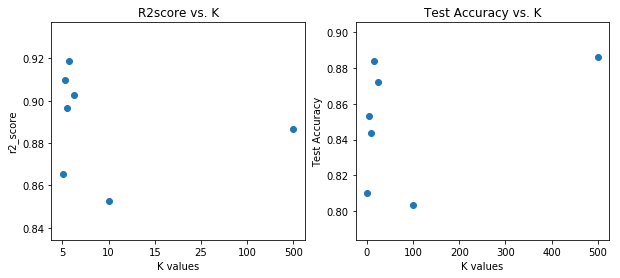

In [344]:
#Try KNN
k_values =[1,5,10,15,25,100,500]
k_score = []
k_test_accuracy =[]
k_models =[]

for i in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=i,n_jobs=4)
    knn_model.fit(X_train[X_train.columns.difference(["party_flip"])],y_train)
    k_models.append(knn_model)
    k_score.append(knn_model.score(X_train[X_train.columns.difference(["party_flip"])],y_train))
    y_pred_test = knn_model.predict(X_test[X_test.columns.difference(["party_flip"])])
    k_test_accuracy.append(accuracy_score(y_test,y_pred_test))
    
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(k_values,k_score)
ax[1].scatter(k_values,k_test_accuracy)
ax[0].set_xticklabels(k_values)

ax[0].set_title("R2score vs. K")
ax[1].set_title("Test Accuracy vs. K")

ax[0].set_xlabel("K values")
ax[0].set_ylabel("r2_score")
ax[1].set_xlabel("K values")
ax[1].set_ylabel("Test Accuracy")  
print("\n")


1 KNN R2score : 0.9096045197740112
1 KNN Test Accuracy:  0.8530805687203792
Confusion Matrix knn-1: 
 [[191   5]
 [ 57 169]]
Percent of non-party flips correctly predicted on test set 96.51474530831099 %
Percent of party flips correctly predicted on test set 0.0 %


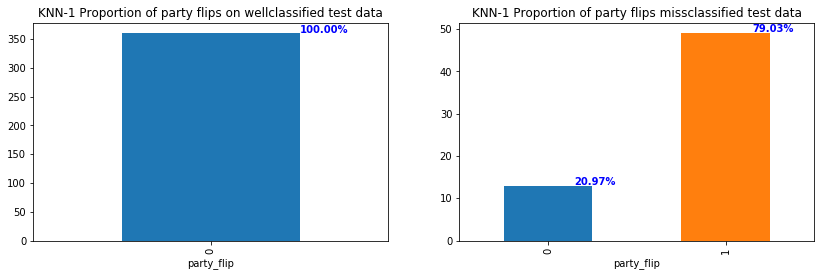

In [353]:
#looking at the missclassifications with logisticRegressionCV

knn_model = KNeighborsClassifier(n_neighbors=5,n_jobs=4)
knn_model.fit(X_train[X_train.columns.difference(["party_flip"])],y_train)
y_pred_test = knn_model.predict(X_test[X_test.columns.difference(["party_flip"])])

 
print("\n1 KNN R2score :",\
      knn_model.score(X_train[X_train.columns.difference(["party_flip"])],y_train))
print("1 KNN Test Accuracy: ",accuracy_score(y_test,y_pred_test))
print("Confusion Matrix knn-1: \n",confusion_matrix(y_test,y_pred_test))
      

miss_class_df = X_test[y_test != y_pred_test]
good_class_df = X_test[y_test == y_pred_test]

print("Percent of non-party flips correctly predicted on test set",
      (good_class_df.party_flip==0).sum() / (X_test.party_flip==0).sum()*100,'%')
print("Percent of party flips correctly predicted on test set",
      (good_class_df.party_flip==1).sum() / (X_test.party_flip==1).sum()*100,'%')

#plot the flips and non flips for each data
fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].set_title('KNN-1 Proportion of party flips on wellclassified test data')
ax[1].set_title('KNN-1 Proportion of party flips missclassified test data')

good_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
miss_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1])

for name, group in (good_class_df.groupby('party_flip')['party_flip']):
    ax[0].text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/good_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

for name, group in (miss_class_df.groupby('party_flip')['party_flip']):
    ax[1].text(int(name)+.15, group.count() + .25, \
    '{0:.2f}'.format(group.count()/miss_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

In [51]:
(good_class_df.party_flip==1).sum() / (X_test.party_flip==1).sum()

0.5714285714285714

### Try Random Forest

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



RF Model Score:  0.9215686274509803
RF Accuracy :  0.8838862559241706
Confusion Matrix: 
 [[191   5]
 [ 44 182]]
Percent of non-party flips correctly predicted on test set 100.0 %
Percent of party flips correctly predicted on test set 0.0 %


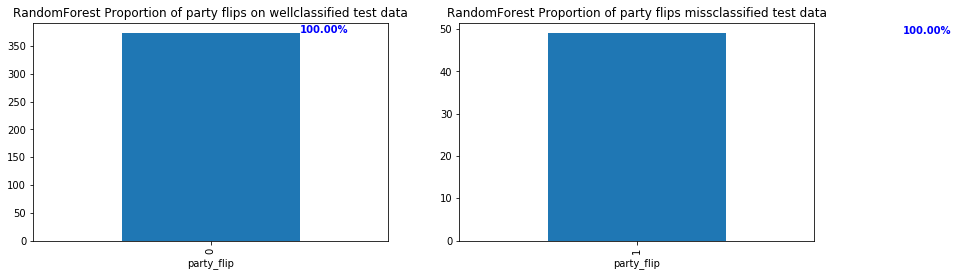

In [352]:
rf_model = RandomForestClassifier(n_jobs=4,random_state=209)
rf_model.fit(X_train[X_train.columns.difference(["party_flip"])],y_train)
print("\nRF Model Score: ",rf_model.score(X_train[X_train.columns.difference(["party_flip"])],y_train))
y_pred_test = rf_model.predict(X_test[X_test.columns.difference(["party_flip"])])
print("RF Accuracy : ",accuracy_score(y_test,y_pred_test))

print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred_test))

miss_class_df = X_test[y_test != y_pred_test]
good_class_df = X_test[y_test == y_pred_test]

print("Percent of non-party flips correctly predicted on test set",
      (good_class_df.party_flip==0).sum() / (X_test.party_flip==0).sum()*100,'%')
print("Percent of party flips correctly predicted on test set",
      (good_class_df.party_flip==1).sum() / (X_test.party_flip==1).sum()*100,'%')

#plot the flips and non flips for each data
fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].set_title('RandomForest Proportion of party flips on wellclassified test data')
ax[1].set_title('RandomForest Proportion of party flips missclassified test data')

good_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
miss_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1])

for name, group in (good_class_df.groupby('party_flip')['party_flip']):
    ax[0].text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/good_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

for name, group in (miss_class_df.groupby('party_flip')['party_flip']):
    ax[1].text(int(name)-.25, group.count() +0, \
    '{0:.2f}'.format(group.count()/miss_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')



AdaBoost R2:  0.9205716184778996
AdaBoost Test Accuracy 0.8838862559241706
Percent of non-party flips correctly predicted on test set 100.0 %
Percent of party flips correctly predicted on test set 0.0 %
Confusion Matrix: 
 [[191   5]
 [ 44 182]]


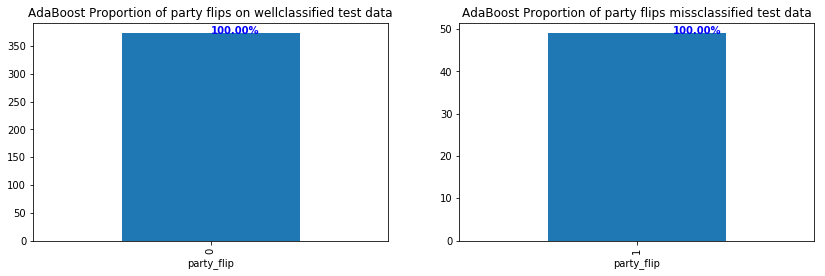

In [351]:
#Boosting

adaBoost_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2))
adaBoost_model.fit(X_train[X_train.columns.difference(["party_flip"])],y_train)
y_pred_test = adaBoost_model.predict(X_test[X_test.columns.difference(["party_flip"])])

print("\nAdaBoost R2: ", adaBoost_model.score(X_train[X_train.columns.difference(["party_flip"])],y_train))
print("AdaBoost Test Accuracy", accuracy_score(y_test,y_pred_test))

miss_class_df = X_test[y_test != y_pred_test]
good_class_df = X_test[y_test == y_pred_test]

print("Percent of non-party flips correctly predicted on test set",
      (good_class_df.party_flip==0).sum() / (X_test.party_flip==0).sum()*100,'%')
print("Percent of party flips correctly predicted on test set",
      (good_class_df.party_flip==1).sum() / (X_test.party_flip==1).sum()*100,'%')

#plot the flips and non flips for each data
fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].set_title('AdaBoost Proportion of party flips on wellclassified test data')
ax[1].set_title('AdaBoost Proportion of party flips missclassified test data')

good_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
miss_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1])

for name, group in (good_class_df.groupby('party_flip')['party_flip']):
    ax[0].text(int(name)+0, group.count() + 0, \
    '{0:.2f}'.format(group.count()/good_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

for name, group in (miss_class_df.groupby('party_flip')['party_flip']):
    ax[1].text(int(name)-.90, group.count() +0, \
    '{0:.2f}'.format(group.count()/miss_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred_test))

In [18]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(X_train.columns.difference(["party_flip"]), rf_model.feature_importances_), key=lambda x: x[1] * -1)
#print(tabulate(values, headers, tablefmt="plain"))

###  NOTES:

1. Logistic CV 90% of the missclassified data occurs when there is a change of party compared to the previous year. No state flips are predicted correctly. 
2. KNN, 100% of the missclassified data occurs when there is a change of party. 5% of the well classified data is party flip. (Better performance)
3. Predicts correctly 100% of the districts that do not change, and ...

Concentrate on improving the states that flip to a different party between elections

Ideas
0. Try non-linear approaches (KNN, Random Forest and Boosting)
1. Increase data by Upsampling and downsampling
2. Increase data by adding more historical data
3. Add demographics data
4. Add redistricting